In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read all the names
words = open('makemore/names.txt').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
# building the vocabulary
chars = sorted(list(set(''.join(words))))  # get all the unique characters
stoi = {ch: i+1 for i, ch in enumerate(chars)}  # char to index
stoi['.'] = 0
itos = {i: ch for ch,i in stoi.items()}  # index to char

print(itos)
print(stoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [4]:
# build the dataset
import random
def build_dataset(words):

    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            #print("".join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

xtr, ytr = build_dataset(words[:n1])
xva, yva = build_dataset(words[n1:n2])
xte, yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn((300,), generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn((27,), generator=g)

parameters = [C, W1, b1, W2, b2]

print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

Number of parameters: 10281


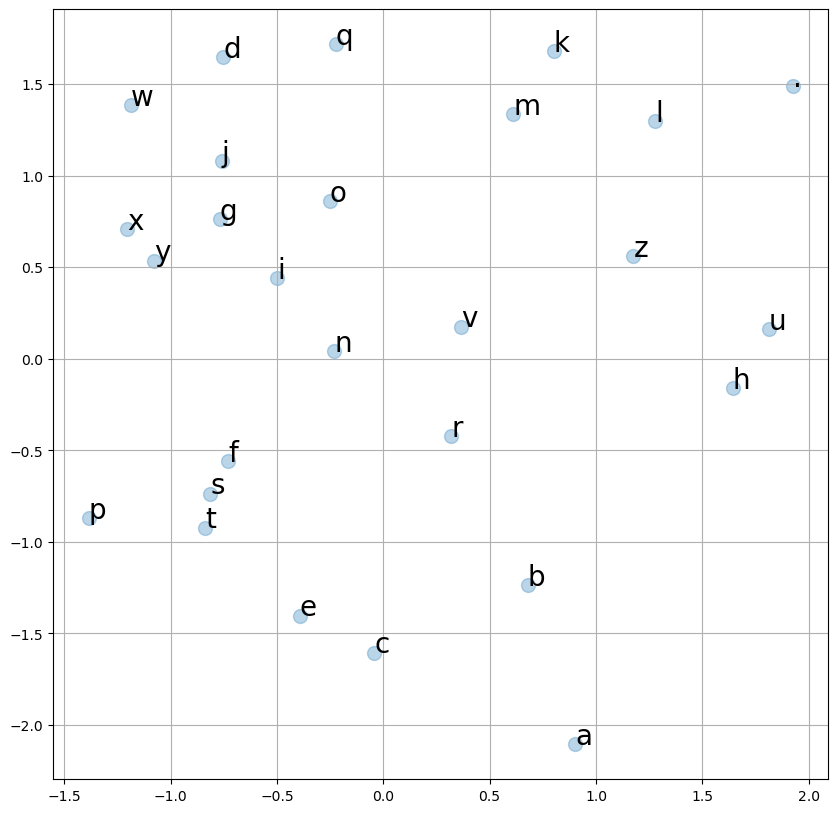

In [6]:
# plot the embeddings before the training
plt.figure(figsize=(10, 10))
plt.scatter(C[:,0].data, C[:,1].data, alpha=0.3, s=100)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], fontsize=20)
plt.grid('minor')

In [7]:
for _ in range(100000):

    # mini-batch
    ix = torch.randint(0, len(xtr), (64,))

    # forward pass
    emb = C[xtr[ix]]
    h = F.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())


2.5490212440490723


In [8]:
emb = C[xtr]
h = F.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ytr)
print(loss.item())


2.340111017227173


In [9]:
emb = C[xva]
h = F.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, yva)
print(loss.item())


2.3478333950042725


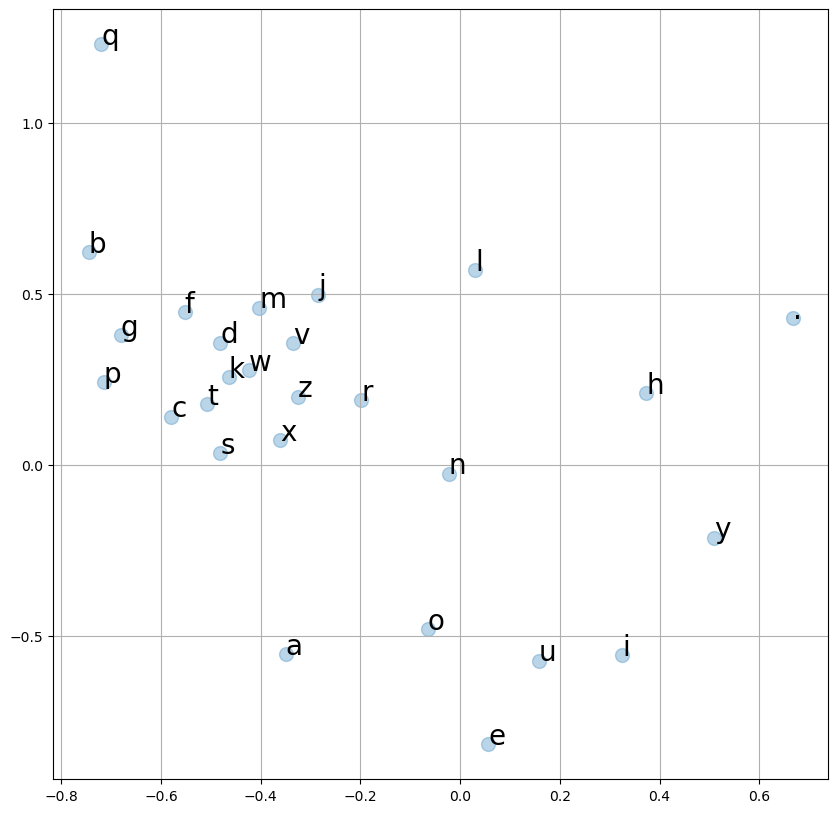

In [10]:
# plot the embeddings

plt.figure(figsize=(10, 10))
plt.scatter(C[:,0].data, C[:,1].data, alpha=0.3, s=100)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], fontsize=20)
plt.grid('minor')